In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from ismember import ismember
import pylab
from util import feature_plot_multidays

In [2]:
data_folder = './data/spselectrodes/'
save_folder = './Figures/Fig6/'
if os.path.exists(save_folder)==False:
    os.mkdir(save_folder)

# ISI violation

In [3]:
isi_violation_rates = pd.read_csv(data_folder+'isi_violation_rate.csv')

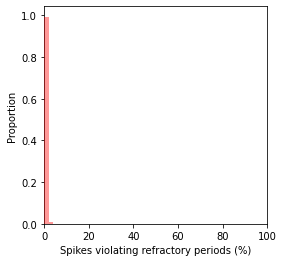

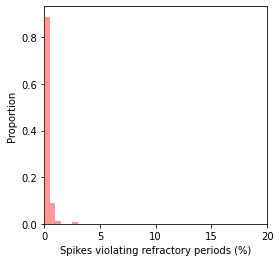

In [4]:
isi_violation = isi_violation_rates['isi_violation_rate'].values
fig, ax = plt.subplots(figsize=(4,4))
maxbin = 1*100
minbin = 0
binsize = 0.02*100
bin_counts_1, bin_edges = np.histogram(isi_violation*100, 
                                       bins=np.arange(minbin,maxbin+binsize,binsize), density=True)
line1 = ax.bar(bin_edges[:-1]+binsize/2,bin_counts_1*binsize,width=binsize*1,color='r', 
               alpha=0.4, zorder=10)
ax.set_xlim([minbin, maxbin])
ax.set_xlabel('Spikes violating refractory periods (%)')
ax.set_ylabel('Proportion')
plt.savefig(save_folder+'/Fig6d.png')

fig, ax = plt.subplots(figsize=(4,4))
maxbin = 0.2*100
minbin = 0
binsize = 0.005*100
bin_counts_1, bin_edges = np.histogram(isi_violation*100, 
                                       bins=np.arange(minbin,maxbin+binsize,binsize), density=True)
line1 = ax.bar(bin_edges[:-1]+binsize/2,bin_counts_1*binsize,width=binsize*1,color='r', 
               alpha=0.4, zorder=10)
ax.set_xlim([minbin, maxbin])
ax.set_xlabel('Spikes violating refractory periods (%)')
ax.set_ylabel('Proportion')
plt.savefig(save_folder+'/Fig6d_zoomin.png')

# Waveform similarity

In [5]:
mice = [1,2,3,4,5,6]
spike_cols = ['t'+str(i) for i in range(1, 30+1)]

r_within = []
for mouse in mice:
    df = pd.read_csv(data_folder+f'spike_dataset_mouse{mouse}.csv')
    dates = df['date'].unique()
    num_days = len(dates)
    neuron_ids = df['neuron_wavemap'].unique()
    stable_neuron_ids = []
    for neuron_id in neuron_ids:
        num_days_neuron = len(df.loc[df['neuron_wavemap']==neuron_id]['date'].unique())
        if(num_days_neuron==num_days):
            stable_neuron_ids.append(neuron_id)
            
    r_within_mouse = []
            
    for neuron_id in stable_neuron_ids:
        df_neuron = df.loc[df['neuron_wavemap']==neuron_id]
        for idx0 in range(len(dates)-1):
            date0 = dates[idx0]
            df_date0 = df_neuron.loc[df_neuron['date']==date0]
            template_date0 = np.mean(df_date0[spike_cols].values,axis=0)
            for idx1 in range(idx0, len(dates)):
                date1 = dates[idx1]
                df_date1 = df_neuron.loc[df_neuron['date']==date1]
                template_date1 = np.mean(df_date1[spike_cols].values,axis=0)
                r_value, p_value = pearsonr(template_date0, template_date1)
                r_within_mouse.append(r_value)
    r_within_mouse = np.hstack(r_within_mouse)
    
    r_within.append(r_within_mouse)
    
r_within = np.hstack(r_within)

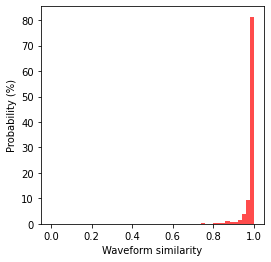

In [6]:
fig, ax = plt.subplots(figsize=(4,4))
maxbin = 1
minbin = 0
binsize = 0.02
mean_value = np.round(np.mean(r_within),2)
std_value = np.round(np.std(r_within),2)

bin_counts_day_within, bin_edges = np.histogram(r_within, 
                                                bins=np.arange(minbin,maxbin+binsize,binsize), 
                                          density=True)

line1 = ax.bar(bin_edges[:-1]+binsize/2,bin_counts_day_within*binsize*100,width=binsize,color='red', alpha=0.7)

ax.set_xlabel('Waveform similarity')
ax.set_ylabel('Probability (%)')
plt.savefig(save_folder+'/Fig6e.png')


# Waveform features

L-ratio and Silhousette score

In [7]:
data_df = pd.read_csv(data_folder+'/cluster_quality_matrix.csv')

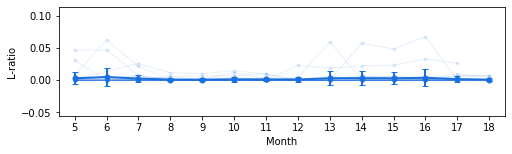

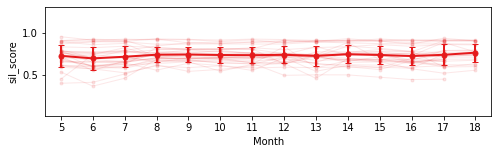

In [8]:
feature_names = ['L-ratio', 'sil_score']
colors = ['#1A6FDF', '#E51A1C']
days = np.arange(5,19)

mouse_channel_ids = data_df['mouse_channel'].unique()
plot_mouse_ids = data_df['mouse'].groupby(data_df['mouse_channel']).mean().astype(int).values
feature_value = {}
for idx, feature_name in enumerate(feature_names):
    feature_value[feature_name] = []
    for date in np.unique(data_df['date']):
            mask = data_df['date'] == date
            df_day = data_df.loc[mask]
            channels_day = df_day['mouse_channel'].groupby(df_day['mouse_channel']).mean().astype(int)
            feature = df_day[feature_name].groupby(df_day['mouse_channel']).mean()
            feature = feature.apply(np.array).values
            feature_ = np.empty((len(mouse_channel_ids),))*np.nan
            feature_[channels_day] = feature
            feature_value[feature_name].append(feature_)
    feature_value[feature_name] = np.vstack(feature_value[feature_name])
    save_path = save_folder + f'/Fig6f_{feature_name}'
    feature_plot_multidays(feature_value[feature_name], plot_mouse_ids,feature_name, days,color=colors[idx], 
                 save_path=save_path)

snr

In [9]:
data_df = pd.read_csv(data_folder+'/snr_metrics.csv')

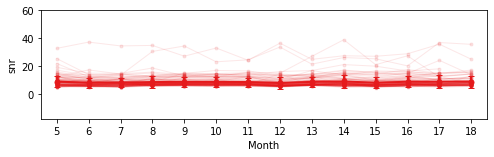

In [10]:
feature_name = 'snr'

mouse_neuron_ids = data_df['mouse_neuron'].unique()
plot_mouse_ids = data_df['mouse'].groupby(data_df['mouse_neuron']).mean().astype(int).values
feature_value = []
days = np.arange(5,19)

for date in np.unique(data_df['date']):
        mask = data_df['date'] == date
        df_day = data_df.loc[mask]
        neurons_day = df_day['mouse_neuron'].groupby(df_day['mouse_neuron']).mean().astype(int)
        feature = df_day[feature_name].groupby(df_day['mouse_neuron']).mean()
        feature = feature.apply(np.array).values
        feature_ = np.empty((len(mouse_neuron_ids),))*np.nan
        feature_[neurons_day] = feature
        feature_value.append(feature_)
feature_value = np.vstack(feature_value)
save_path = save_folder + '/Fig6h_SNR.png'
feature_plot_multidays(feature_value, plot_mouse_ids,feature_name, days, color='#E51A1C', 
             save_path=save_path)

duration, peak trough ratio, repolarization slope, recovery slope, amplitude

In [11]:
df = []
for mouse in mice:
    df_mouse = pd.read_csv(data_folder+f'spike_dataset_mouse{mouse}.csv')
    df.append(df_mouse)
df = pd.concat(df)

In [12]:
mouse_neuron_id = -1
mouse_neuron_key = 'mouse_wavemap'
for mouse in np.unique(df['mouse']):
    mask1 = df['mouse'] == mouse
    for neuron_id in df['neuron_wavemap'].unique():
        mask2 = df['neuron_wavemap'] == neuron_id
        mask = mask1&mask2
        if(np.sum(mask>0)>0):
            mouse_neuron_id = mouse_neuron_id + 1
            df.loc[mask,mouse_neuron_key] = mouse_neuron_id

/home/siyuan/disk1/weiwen/VisualStimulation/publish_codes_final/util.py:355: RuntimeWarning: invalid value encountered in multiply
  feature_add_day_info = np.empty((num_days, len(select_indices)))*np.nan


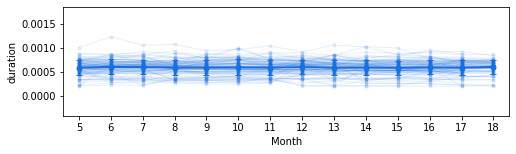

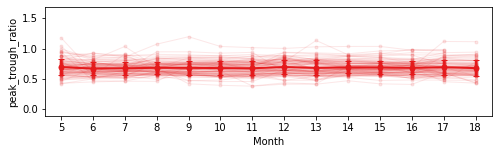

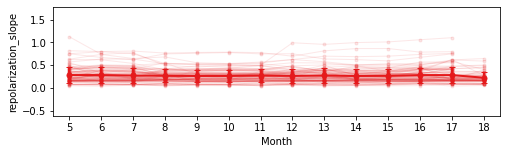

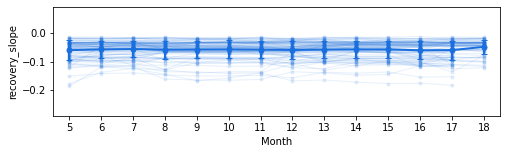

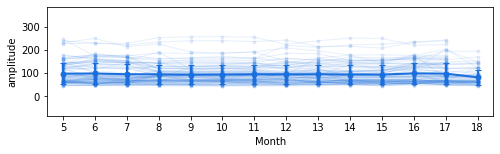

In [13]:
feature_names = np.array(['peak_to_valley', 'peak_trough_ratio', 
       'repolarization_slope', 'recovery_slope', 'amplitude'])
feature_names_show = np.array(['duration', 'peak_trough_ratio', 
       'repolarization_slope', 'recovery_slope', 'amplitude'])
feature_value = {}
colors = ['#1A6FDF', '#E51A1C', '#E51A1C', '#1A6FDF', '#1A6FDF']
days = np.arange(5,19)

neurons = df[mouse_neuron_key].unique()
plot_mouse_ids = df['mouse'].groupby(df[mouse_neuron_key]).mean().astype(int).values
feature_value['mouse_id'] = plot_mouse_ids
for idx, feature_name in enumerate(feature_names):
    feature_name_show = feature_names_show[idx]
    feature_value[feature_name] = []
    for date in np.unique(df['date']):
            mask = df['date'] == date
            df_day = df.loc[mask]
            neurons_day = df_day[mouse_neuron_key].groupby(df_day[mouse_neuron_key]).mean().astype(int)
            feature = df_day[feature_name].groupby(df_day[mouse_neuron_key]).mean()
            feature = feature.apply(np.array).values
            feature_ = np.empty((len(neurons),))*np.nan
            feature_[neurons_day] = feature
            feature_value[feature_name].append(feature_)
    feature_value[feature_name] = np.vstack(feature_value[feature_name])
    save_path = save_folder + f'/Fig6_{feature_name_show}.png'
    feature_plot_multidays(feature_value[feature_name], plot_mouse_ids,feature_name_show, days, color=colors[idx], 
                 save_path=save_path)

# Stable percentage

In [14]:
df = []
for mouse in mice:
    df_mouse = pd.read_csv(data_folder+f'spike_dataset_mouse{mouse}.csv')
    df_mouse['mouse'] = mouse
    df.append(df_mouse)
df = pd.concat(df)

In [15]:
months = np.arange(14) + 5

percentage = {}
percentage_concat = np.empty((len(mice), len(df['date'].unique())))*np.nan
days = df['date'].unique()
for mouse_id_id, mouse in enumerate(mice):
    df_mouse = df.loc[df['mouse']==mouse]
    mouse_days = df_mouse['date'].unique()
    num_neurons = np.zeros((len(df_mouse['date'].unique())))
    for idx,date in enumerate(df_mouse['date'].unique()):
        num_neurons[idx] = len(df_mouse.loc[df_mouse['date']==date]['neuron_wavemap'].unique())
    percentage[mouse] = num_neurons/np.max(num_neurons)
    
percentage_concat = np.empty((len(mice), len(df['date'].unique())))*np.nan
days = df['date'].unique()
for mouse_id_id, mouse in enumerate(mice):
    df_mouse = df.loc[df['mouse']==mouse]
    mouse_days = df_mouse['date'].unique()
    indices,_ = ismember(days, mouse_days)
    percentage_concat[mouse_id_id, indices] = percentage[mouse]
        
percentage_mean = np.nanmean(percentage_concat,axis=0)
percentage_std = np.nanstd(percentage_concat,axis=0)

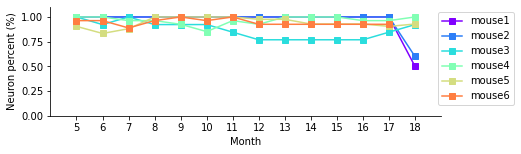

In [16]:
mouse_ids = list(percentage.keys())
NumMice = len(mouse_ids)
x = np.arange(len(months))
cm = pylab.get_cmap('rainbow')
colors = []
for i in range(NumMice):
    colors.append(cm(1. * i / NumMice)) 

fig, ax = plt.subplots(figsize=(len(months)/2, 2))
for idx, mouse_id in enumerate(mouse_ids):
    ax.plot(x, percentage_concat[idx,:],color=colors[idx], label=f'mouse{mouse_id}', marker='s')

ax.set_xticks(range(len(months)))
ax.set_xticklabels(list(months))
ax.set_xlim([-1,len(months)])
ax.set_ylim([0,1.1])
ax.set_xlabel('Month')
ax.set_ylabel('Neuron percent (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(bbox_to_anchor=(0.6,0,0.6,1))
ax.grid(False)
plt.savefig(save_folder+f'/Fig6k.png')